In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

## Tabla train

In [ ]:
with open('county_id_to_name_map.json', 'r') as file:
    county_id_to_name = json.load(file)

In [2]:
cat_vars = [
    'county',
    'is_business',
    'product_type',
    'is_consumption',
    'data_block_id',
    'row_id',
    'prediction_unit_id'
]


In [3]:
train = pd.read_csv('../data/train.csv',
                    dtype=dict(zip(cat_vars, ['category']*len(cat_vars))))

train['datetime'] = pd.to_datetime(train['datetime'])

#### Utilidades

In [4]:
def perc_by_category(col_cat: str, data: pd.DataFrame) -> float:
    return (data[col_cat].value_counts(normalize=True)*100).round(2)

def bar_plot(
        categories: list,
        freqs: list,
        xlabel: str,
        ylabel: str,
        title: str,
        is_rotated:bool = False,
        angle:float = 45
        ):
    plt.bar(categories, freqs)
    if is_rotated:
        plt.xticks(rotation=angle)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

### Análisis univariado

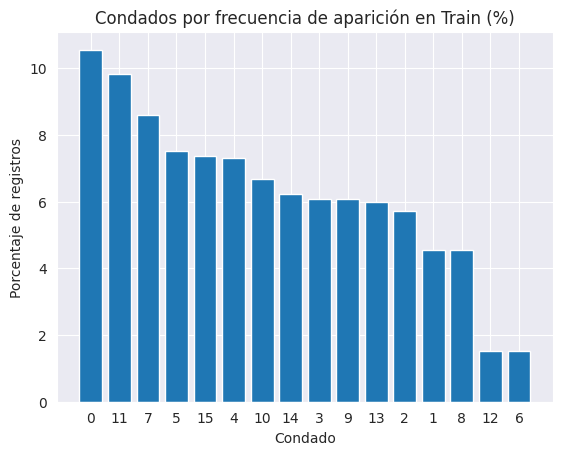

In [10]:
perc_county = perc_by_category('county', train)
perc_county = perc_county.reset_index()
perc_county['county'] = perc_county['county']
bar_plot(
    perc_county['county'],
    perc_county['proportion'],
    'Condado',
    'Porcentaje de registros',
    'Condados por frecuencia de aparición en Train (%)'
)

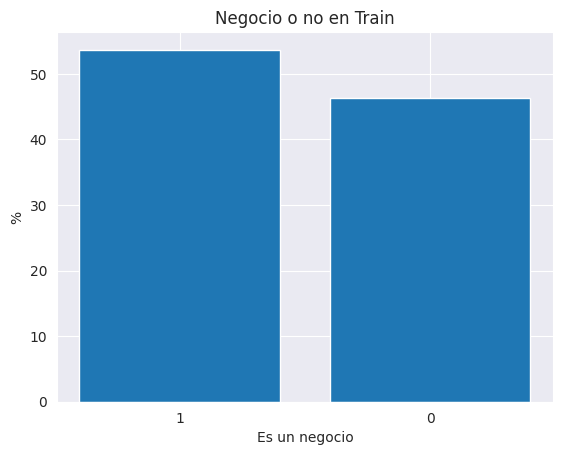

In [11]:
perc_is_business = perc_by_category('is_business', train)
bar_plot(
    perc_is_business.index,
    perc_is_business.values,
    'Es un negocio',
    '%',
    'Negocio o no en Train')

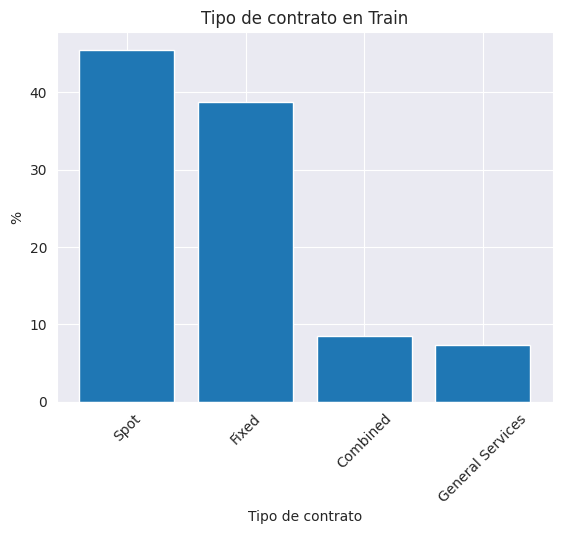

In [12]:
product_type_id_to_name = {
    '0': 'Combined',
    '1': 'Fixed',
    '2': 'General Services',
    '3': 'Spot'
}

perc_product_type = perc_by_category('product_type', train)

perc_product_type = perc_product_type.reset_index()

perc_product_type['name'] = perc_product_type['product_type'].replace(product_type_id_to_name)

bar_plot(
    perc_product_type['name'],
    perc_product_type['proportion'],
    'Tipo de contrato',
    '%',
    'Tipo de contrato en Train',
    is_rotated=True)

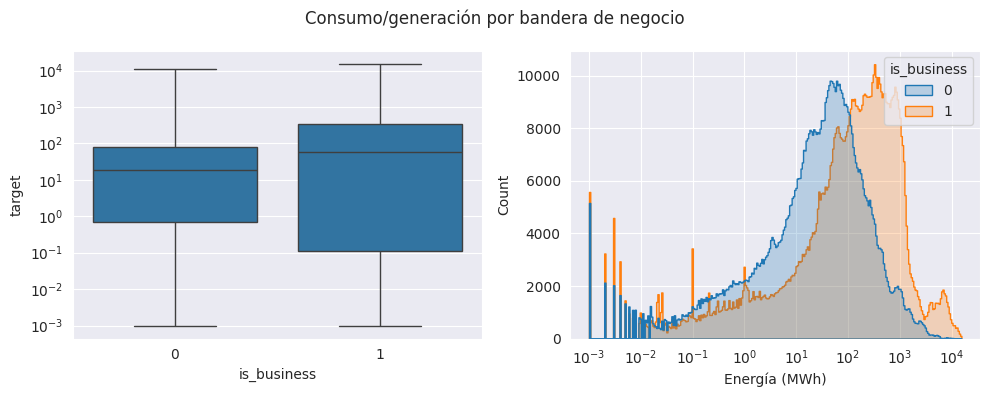

In [13]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

sns.boxplot(train, x='is_business', y='target', log_scale=True)

plt.subplot(1,2,2)

ax = sns.histplot(train, x='target', hue='is_business', element='step', log_scale=True)
plt.xlabel('Energía (MWh)')

plt.suptitle("Consumo/generación por bandera de negocio")

plt.tight_layout()

### Segmentos

Para identificar un segmento lo hacemos mediante la tripleta (`county`, `is_business`, `product_type`).

In [64]:
# Conteo de número único de segmentos en train
train[['county','is_business','product_type']].drop_duplicates().shape

(69, 3)

En la tabla train hay 69 segmentos. Un identificador alterno de segmento es la variable `prediction_unit_id`.

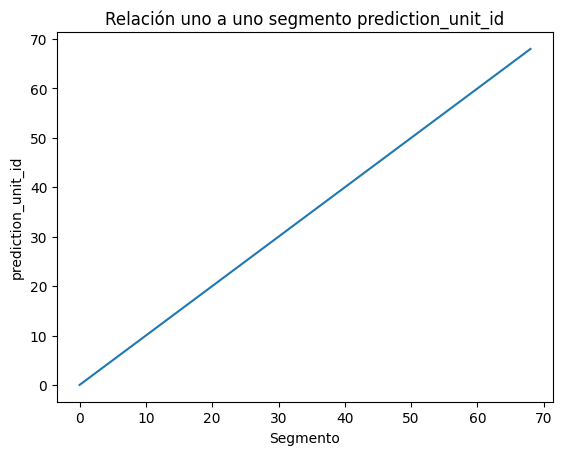

In [72]:
# Verificar si la relación entre segmento y prediction_unit_id es biunívoca
segments_pred_ids = train[['county','is_business','product_type', 'prediction_unit_id']].drop_duplicates()
segments_pred_ids['prediction_unit_id'] = segments_pred_ids['prediction_unit_id'].astype(int)
segments_pred_ids = segments_pred_ids.sort_values('prediction_unit_id')
plt.plot(segments_pred_ids['prediction_unit_id'].values)
plt.xlabel('Segmento')
plt.ylabel('prediction_unit_id')
plt.title('Relación uno a uno segmento prediction_unit_id')
plt.show()

### Completitud de series temporales por segmento

**Def (Segmento activo)** Si un segmento presenta al menos un registro en un instante de tiempo *t*, decimos que el segmento es activo en *t*. 

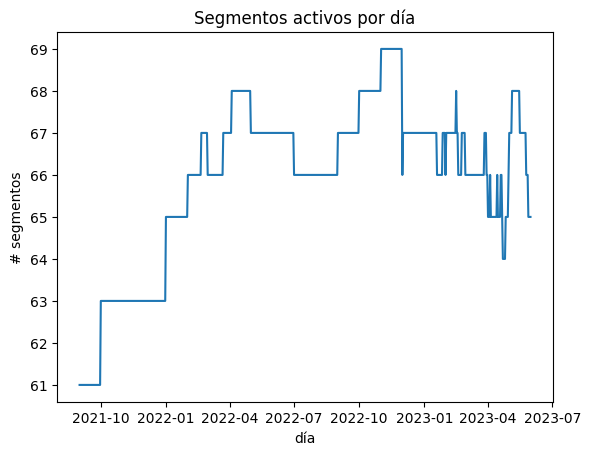

In [62]:
train['date'] = train['datetime'].dt.date
segments_by_day = train.groupby('date', observed=True)['prediction_unit_id'].nunique()
plt.plot(segments_by_day)
plt.title('Segmentos activos por día')
plt.xlabel('día')
plt.ylabel('# segmentos')
plt.show()

Se observa que existen segmentos no activos para algunos días. Además, hay al menos 61 segmentos activos y máximo 69.

#### Naturaleza de segmentos inactivos

##### Inactividad en momentos intermedios

Se verifica que los segmentos con `prediction_unit_id` en $\{21, 26, 41, 44, 47, 68\}$ carecen de datos para ciertas horas desde su inicio de operación hasta último registro de operación.

In [ ]:
for code_unit in train['prediction_unit_id'].unique():
    data_unit =  train[
        (train['prediction_unit_id'] == code_unit)].sort_values('datetime')
    min_date, max_date = data_unit['datetime'].min(), data_unit['datetime'].max()
    time_range = pd.date_range(start=min_date, end=max_date, freq='1H')
    periods = len(time_range) 
    if periods != data_unit['datetime'].nunique():
        num_missing_times = len(set(time_range).difference(set(data_unit['datetime'])))
        print(f'prediction_unit_id {code_unit}: {round(num_missing_times/periods*100,2)}% en intervalo de tiempo {min_date}, {max_date}')

prediction_unit_id 21: 4.86% en intervalo de tiempo 2021-09-01 00:00:00, 2023-05-31 23:00:00
prediction_unit_id 26: 27.65% en intervalo de tiempo 2021-09-01 00:00:00, 2023-03-29 23:00:00
prediction_unit_id 41: 59.32% en intervalo de tiempo 2021-09-01 00:00:00, 2023-05-15 23:00:00
prediction_unit_id 44: 7.26% en intervalo de tiempo 2021-09-01 00:00:00, 2023-05-27 23:00:00
prediction_unit_id 47: 20.76% en intervalo de tiempo 2021-09-01 00:00:00, 2023-05-24 23:00:00
prediction_unit_id 68: 67.45% en intervalo de tiempo 2022-11-01 00:00:00, 2023-05-31 23:00:00


##### Inactividad por inexistencia de segmento

Se identifican aquellos segmentos cuyo rango de operación no corresponde con el mayor rango de operación. Se encuentra que los segmentos con `prediction_unit_id` en $\{21, 41, 44, 47, 61, 62, 63, 64, 65, 66, 67, 68\}$ tienen rango de actividad menor.

In [83]:
range_time_by_segments = train.groupby('prediction_unit_id', observed=True)['datetime'].agg(lambda x: x.max()-x.min())
range_time_by_segments[range_time_by_segments!=range_time_by_segments.max()]

prediction_unit_id
26   574 days 23:00:00
41   621 days 23:00:00
44   633 days 23:00:00
47   630 days 23:00:00
61   607 days 23:00:00
62   607 days 23:00:00
63   607 days 23:00:00
64   546 days 23:00:00
65   515 days 23:00:00
66   515 days 23:00:00
67   484 days 23:00:00
68   211 days 23:00:00
Name: datetime, dtype: timedelta64[ns]

##### Segmentos siempre activos

In [33]:
unique_segments_by_day = train.groupby('date')['prediction_unit_id'].unique().values
intersection = set(unique_segments_by_day[0])

for segments_in_day in unique_segments_by_day:
    intersection &= set(segments_in_day)

date_min = train['datetime'].min()
date_max = train['datetime'].max()

print(f'prediction_unit_id de segmentos que registraron valores para al menos una hora todos los días ({date_min}, {date_max}):\n{intersection}\nEn total son {len(intersection)} segmentos.')

prediction_unit_id de segmentos que registraron valores para al menos una hora todos los días (2021-09-01 00:00:00, 2023-05-31 23:00:00):
{'31', '51', '45', '8', '15', '35', '56', '20', '60', '50', '32', '6', '18', '55', '57', '4', '54', '42', '28', '33', '14', '1', '34', '39', '48', '3', '53', '29', '37', '16', '43', '5', '46', '58', '23', '24', '10', '7', '2', '36', '49', '27', '12', '30', '59', '19', '22', '52', '0', '11', '25', '9', '13', '38', '17', '40'}
En total son 56 segmentos.


### Agrupamiento de segmentos (activos)

Se realiza agrupación de las series de tiempo de cada segmento que resultan de promediar por día el consumo o generación. El método empleado fue K-Means con métrica DTW. Los resultados se muestran normalizados para hacer incapie en similitud de patrones.

In [40]:
# Filtrar dataset con segmentos que al menos registraron valores una vez todos los días
train_filter = train[train['prediction_unit_id'].isin(intersection)].copy()

# Número de clústeres k
k = 8

# K-Means para series de tiempo
k_means_consumers = TimeSeriesKMeans(n_clusters=k, metric="dtw")
k_means_producers = TimeSeriesKMeans(n_clusters=k, metric="dtw")

# Promedios diarios por segmento cuando se comporta como consumidor
st_daily_segments_consumers = train_filter[train_filter['is_consumption']=='1'].\
    groupby(['prediction_unit_id','date'], observed=True)['target'].mean().reset_index().\
    groupby('prediction_unit_id', observed=True)['target'].agg(list)

# Promedios diarios por segmento cuando se comporta como productor
st_daily_segments_producers = train_filter[train_filter['is_consumption']=='0'].\
    groupby(['prediction_unit_id','date'], observed=True)['target'].mean().reset_index().\
    groupby('prediction_unit_id', observed=True)['target'].agg(list)

# Requisito de formato de método TimeSeriesKMeans
list_daily_st_segmemts_consumers = [pd.Series(st) for st in st_daily_segments_consumers]
list_daily_st_segmemts_producers = [pd.Series(st) for st in st_daily_segments_producers]

# Se verificó que cada registro de segmento como productor tiene registro como consumidor
n_days = len(list_daily_st_segmemts_consumers[0])
n_segments = len(list_daily_st_segmemts_consumers)

# Normalizar datos de acuerdo a su respectiva serie
for idx_segment in range(n_segments):
    list_daily_st_segmemts_consumers[idx_segment] = MinMaxScaler().fit_transform(
        list_daily_st_segmemts_consumers[idx_segment].values.reshape(-1,1))
    list_daily_st_segmemts_producers[idx_segment] = MinMaxScaler().fit_transform(
        list_daily_st_segmemts_producers[idx_segment].values.reshape(-1,1))
    list_daily_st_segmemts_consumers[idx_segment] = list_daily_st_segmemts_consumers[idx_segment].reshape(n_days)
    list_daily_st_segmemts_producers[idx_segment] = list_daily_st_segmemts_producers[idx_segment].reshape(n_days)

# Etiquetamiento de segmentos como consumidores/productores
labels_consumers = k_means_consumers.fit_predict(list_daily_st_segmemts_consumers)
labels_producers = k_means_producers.fit_predict(list_daily_st_segmemts_producers)

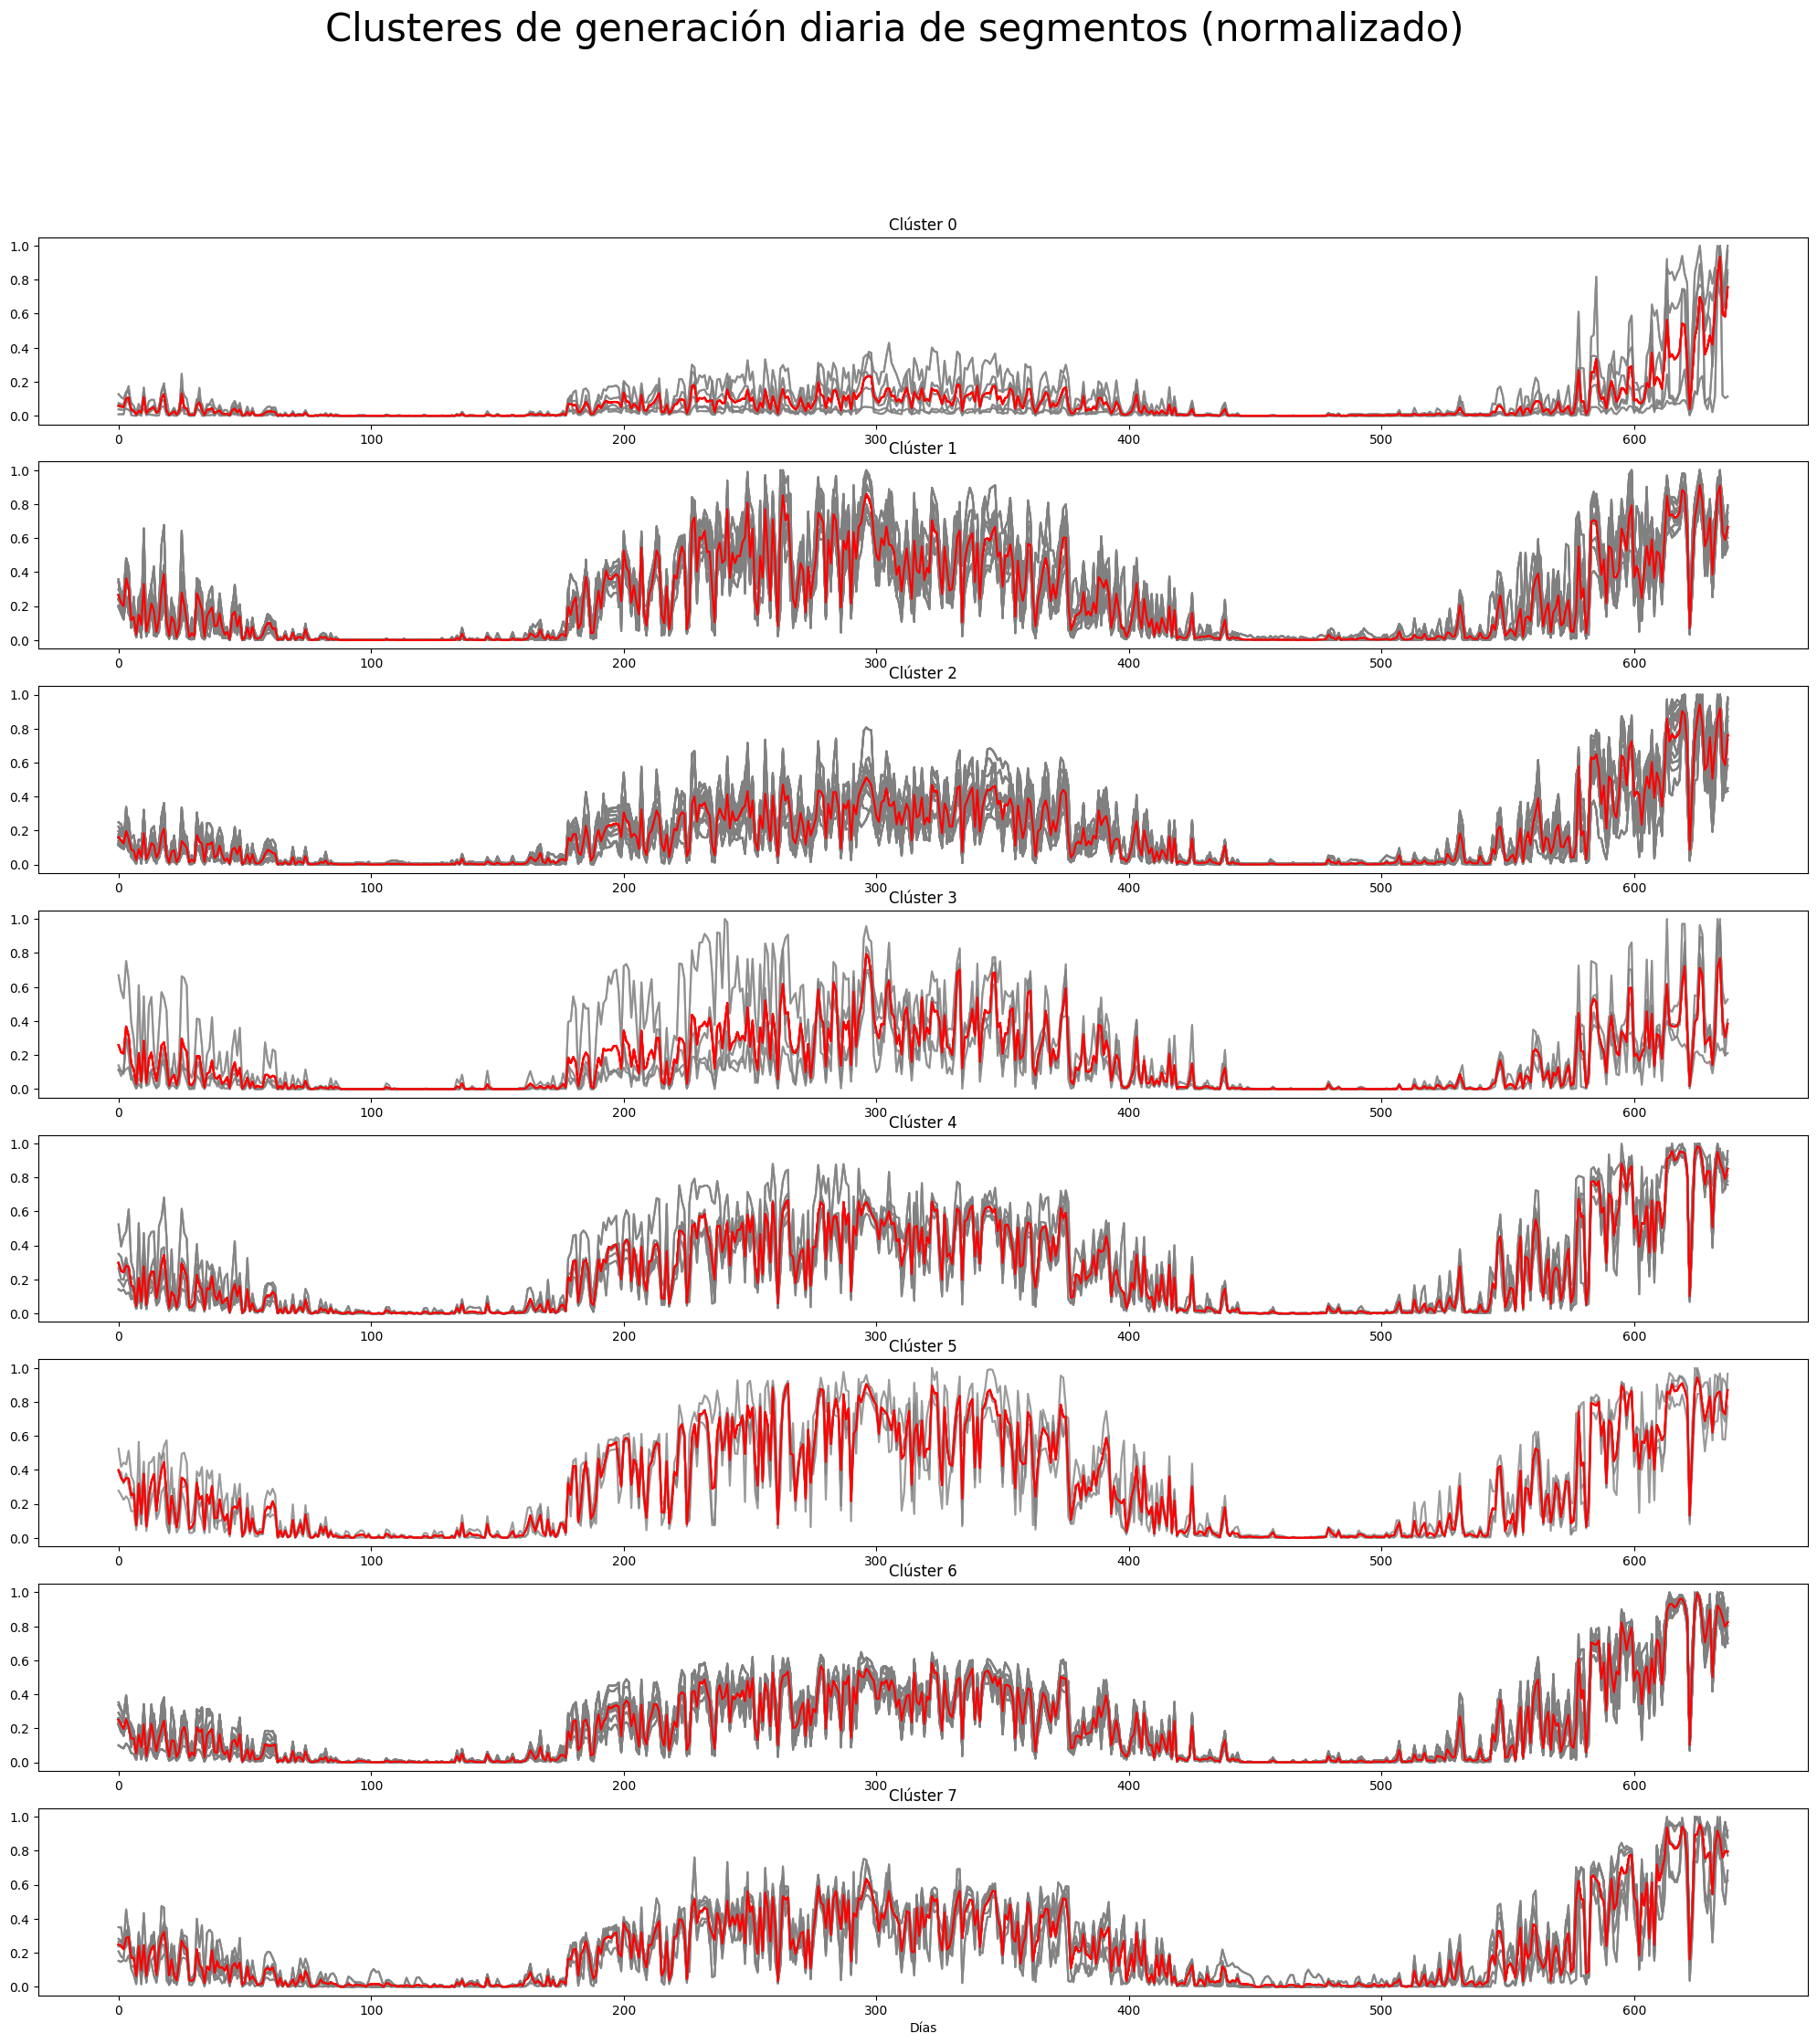

In [57]:
fig, axs = plt.subplots(k, figsize=(25,25))
fig.suptitle('Clusteres de generación diaria de segmentos (normalizado)', fontsize=30)

for lb in labels_producers:
    cluster = []
    for j in range(len(labels_producers)):
            if lb == labels_producers[j]:
                axs[lb].plot(list_daily_st_segmemts_producers[j], c="gray", alpha=0.4)
                cluster.append(list_daily_st_segmemts_producers[j])
    axs[lb].plot(np.average(np.vstack(cluster),axis=0), c="red")
    axs[lb].set_title("Clúster " + str(lb))

axs[-1].set_xlabel("Días")

plt.show()

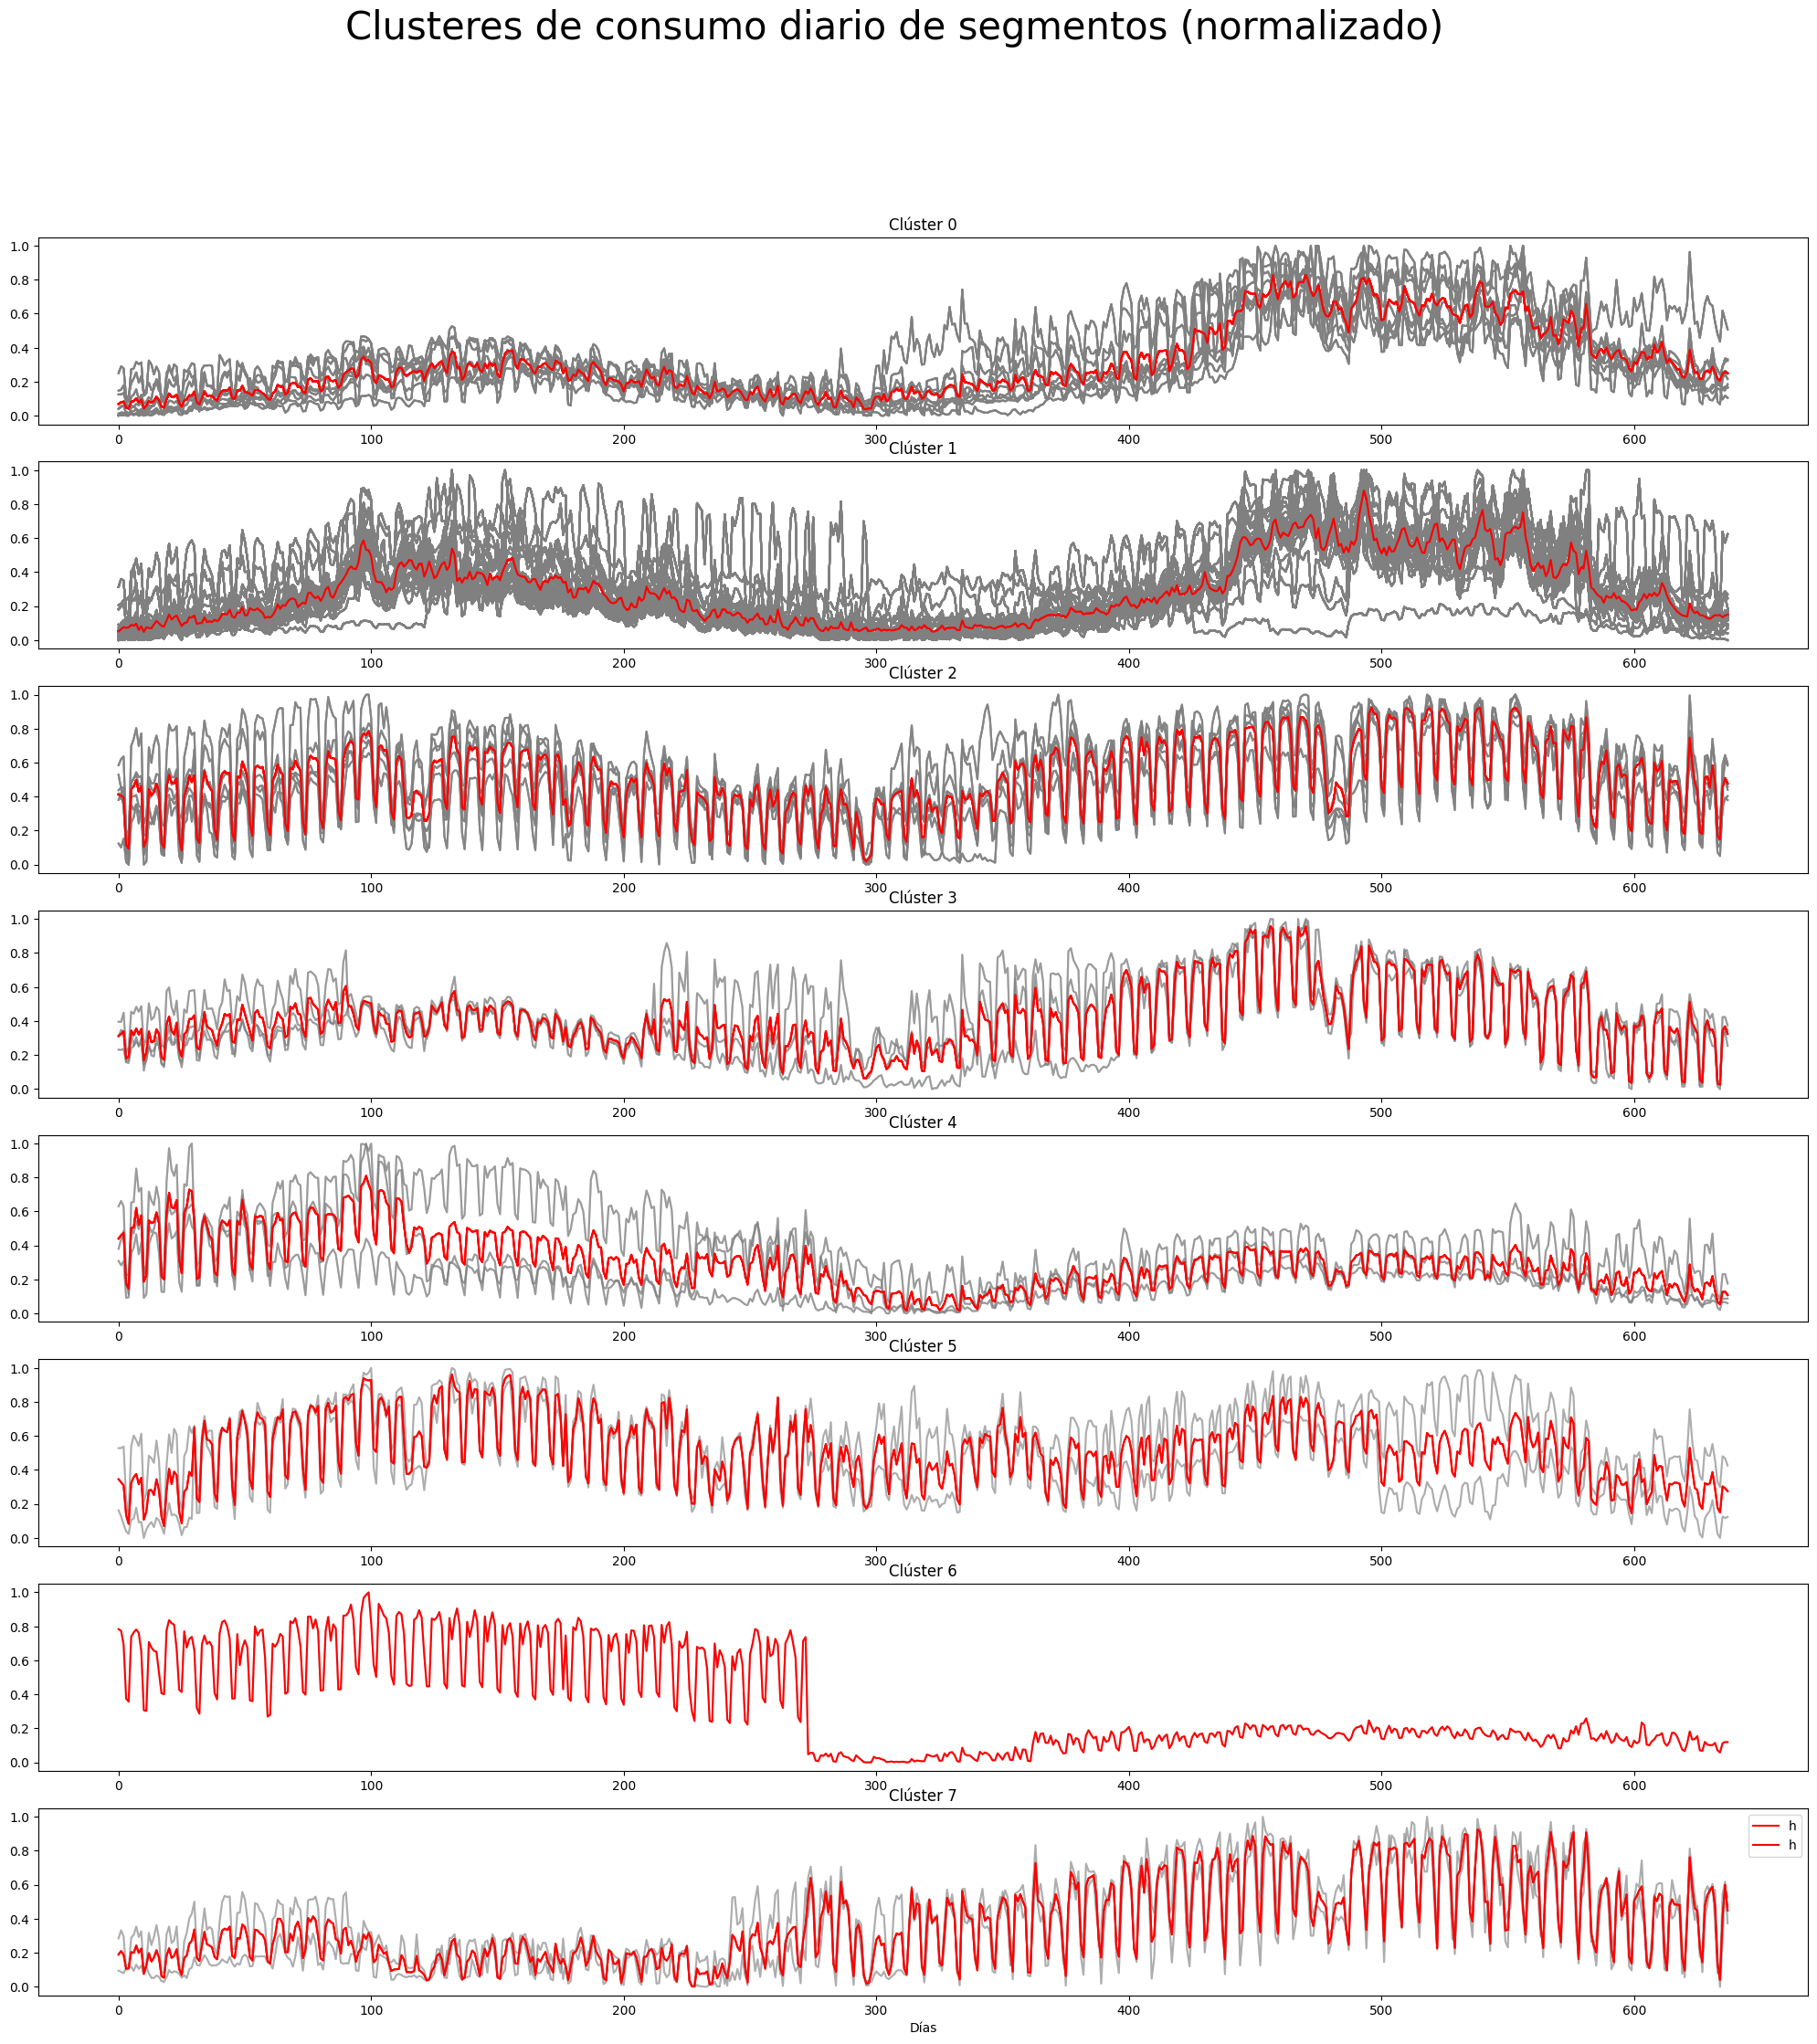

In [ ]:
fig, axs = plt.subplots(k, figsize=(25,25))
fig.suptitle('Clusteres de consumo diario de segmentos (normalizado)', fontsize=30)

for lb in labels_consumers:
    cluster = []
    for j in range(len(labels_consumers)):
            if lb == labels_consumers[j]:
                axs[lb].plot(list_daily_st_segmemts_consumers[j], c="gray", alpha=0.4)
                cluster.append(list_daily_st_segmemts_consumers[j])
    axs[lb].plot(np.average(np.vstack(cluster),axis=0), c="red")
    axs[lb].set_title("Clúster " + str(lb))

axs[-1].set_xlabel("Días")
   
plt.show()

#### Patrones de generación/consumo por condado

In [105]:
consumption_county = train_filter[train_filter['is_consumption']=='1'].groupby(['county','date'])['target'].sum().reset_index().groupby('county')['target'].agg(list)
production_county = train_filter[train_filter['is_consumption']=='0'].groupby(['county','date'])['target'].sum().reset_index().groupby('county')['target'].agg(list)

# Requisito de formato de método TimeSeriesKMeans
list_consumption_county = [pd.Series(st) for st in consumption_county]
list_production_county = [pd.Series(st) for st in production_county]

# Se verificó que cada registro de segmento como productor tiene registro como consumidor
n_days = len(list_consumption_county[0])
n_counties = len(list_consumption_county)

# Normalizar datos de acuerdo a su respectiva serie
for idx in range(n_counties):
    list_consumption_county[idx] = MinMaxScaler().fit_transform(
        list_consumption_county[idx].values.reshape(-1,1))
    list_production_county[idx] = MinMaxScaler().fit_transform(
        list_production_county[idx].values.reshape(-1,1))
    list_consumption_county[idx] = list_consumption_county[idx].reshape(n_days)
    list_production_county[idx] = list_production_county[idx].reshape(n_days)

C:\Users\david.montoya\AppData\Local\Temp\ipykernel_28300\1372377155.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  consumption_county = train_filter[train_filter['is_consumption']=='1'].groupby(['county','date'])['target'].sum().reset_index().groupby('county')['target'].agg(list)
C:\Users\david.montoya\AppData\Local\Temp\ipykernel_28300\1372377155.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  consumption_county = train_filter[train_filter['is_consumption']=='1'].groupby(['county','date'])['target'].sum().reset_index().groupby('county')['target'].agg(list)
C:\Users\david.montoya\AppData\Local\Temp\

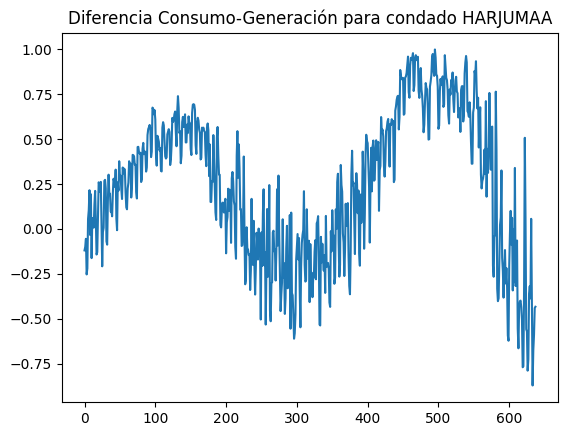

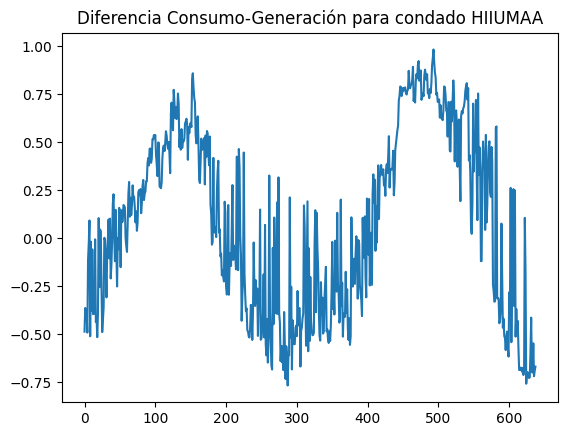

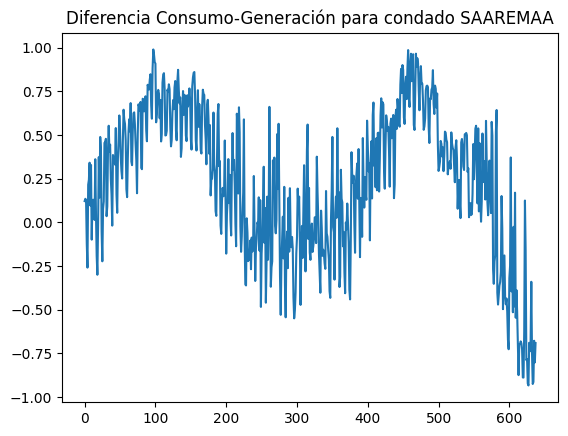

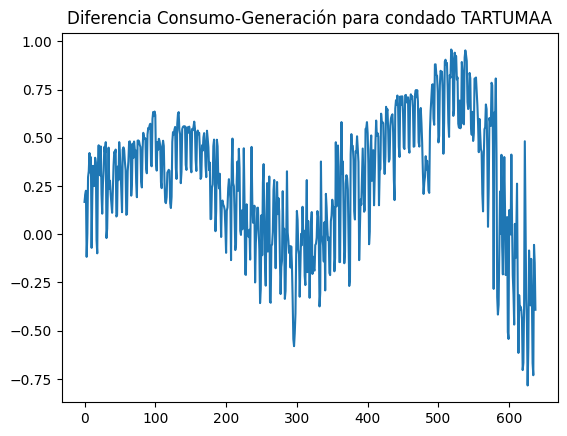

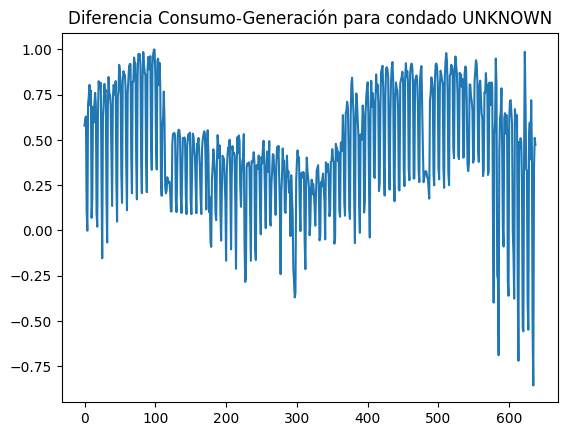

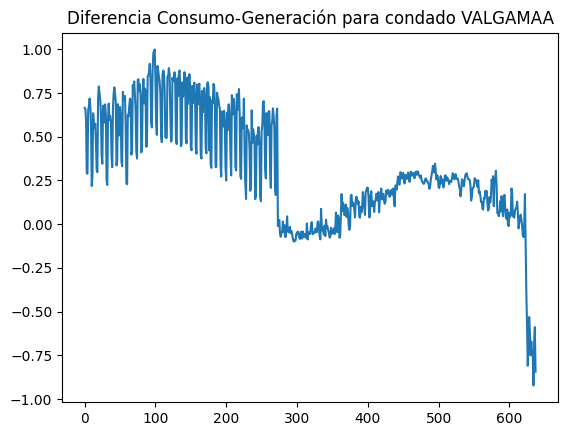

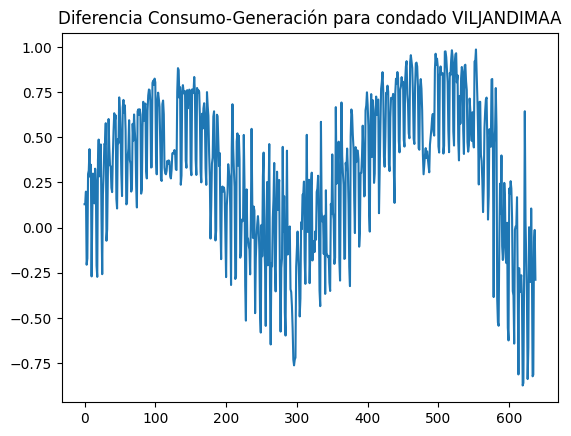

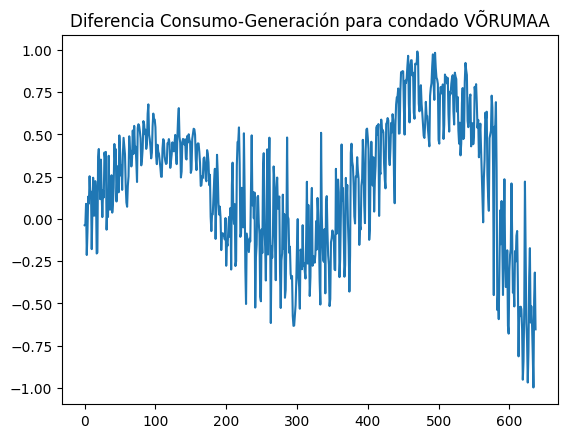

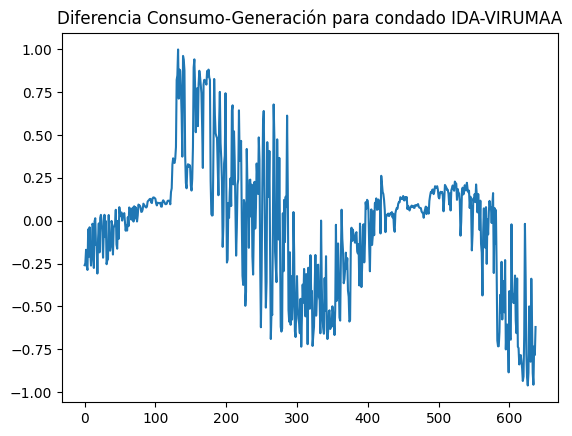

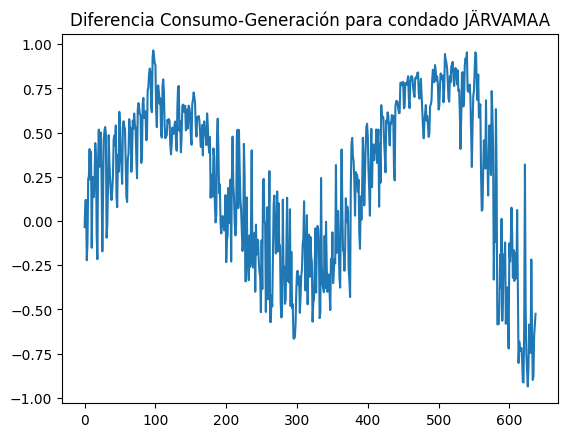

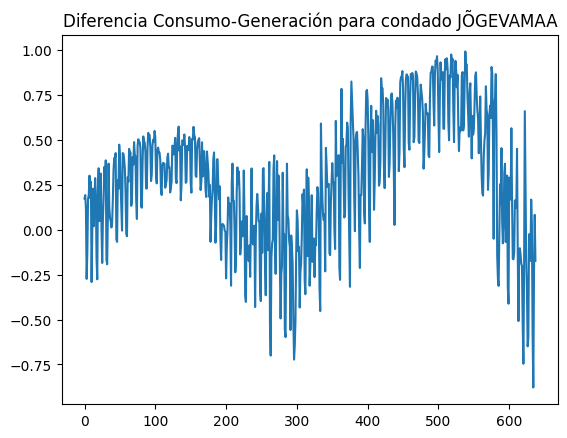

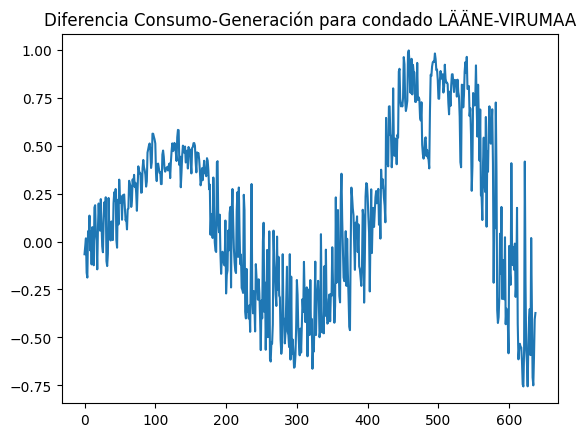

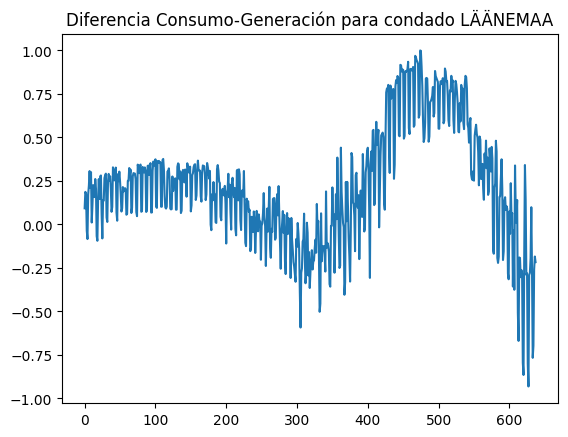

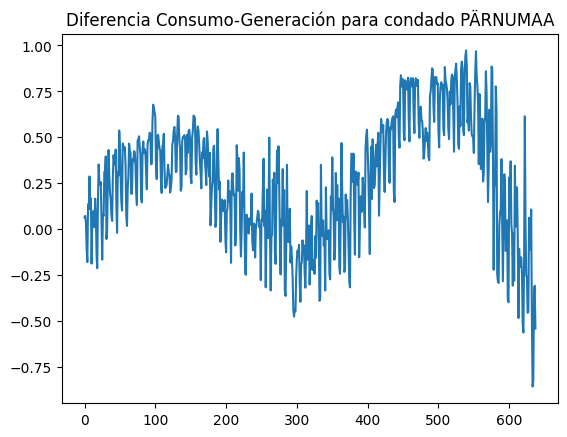

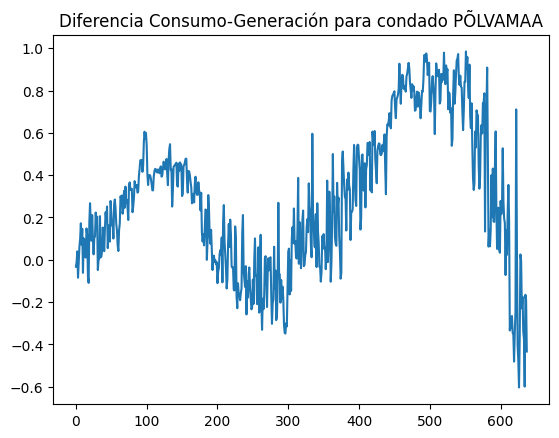

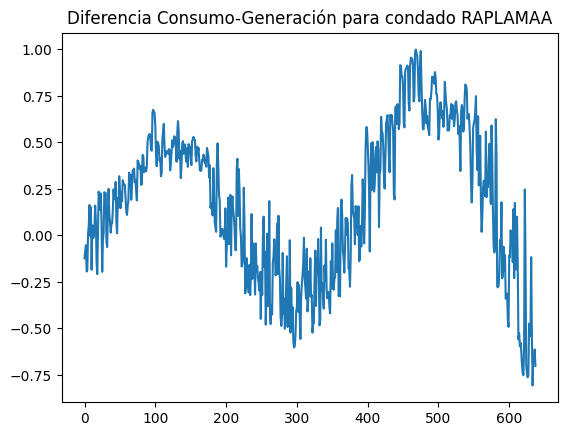

In [117]:
diff = [list_consumption_county[i]-list_production_county[i] for i in range(n_counties)]

for st, key_county in zip(diff, consumption_county.index):
    plt.plot(st)
    plt.title(f'Diferencia Consumo-Generación para condado {county_id_to_name[key_county]}')
    plt.show()